In [ ]:
import torch
from utils import (
    load_config,
    load_model,
    create_metadata_tensor,
    load_slices,
    transform_to_hu,
    tensor_stack,
    window,
    zoom_resize,
    normalise_slices,
)
import matplotlib.pyplot as plt

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Nisha\anaconda3\envs\osteo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load config
config = load_config("./model/config.json")
# Load the model
model = load_model(config, "./model/model.pt", device)

In [ ]:
# Define age and sex for the model
age = 65  # Example age
sex = "female"  # Example sex
# Get normalization statistics for age
age_norm_stats = config["norm_stats"]["age"]
# Create metadata tensor
metadata = create_metadata_tensor(
    age, sex, age_norm_stats["mean"], age_norm_stats["std"], device
)
print(f"Metadata tensor: {metadata}")

Metadata tensor: tensor([-0.3066,  0.0000], device='cuda:0')


In [4]:
# Load slices
slice_paths = [
    "./data/CT000070.dcm",
    "./data/CT000071.dcm",
    "./data/CT000072.dcm",
]
slices = load_slices(slice_paths)
# Convert to Hounsfield Units (HU)
slices = transform_to_hu(slices)

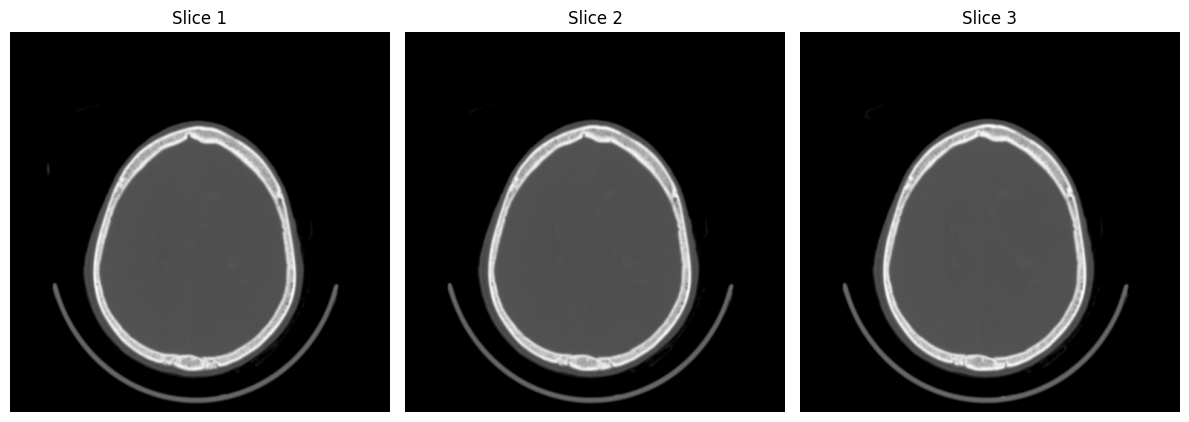

In [5]:
# Window the slices for display, input to model is not windowed
windowed_slices = window(slices, window_center=600, window_width=2800)
# Visualise the slices
plt.figure(figsize=(12, 6))
for i, slice_ in enumerate(windowed_slices):
    plt.subplot(1, len(windowed_slices), i + 1)
    plt.imshow(slice_, cmap="gray")
    plt.axis("off")
    plt.title(f"Slice {i + 1}")
plt.tight_layout()
plt.show()

In [ ]:
# Stack the slices into a tensor
slices_tensor = tensor_stack(slices, device)
# Resize the slices to the model's input size, as some images are not 512x512
slices_tensor = zoom_resize(slices_tensor, config["input_size"])
# Normalise the slices
image_norm_stats = config["norm_stats"]["image"]
slices_tensor = normalise_slices(
    slices_tensor, image_norm_stats["mean"], image_norm_stats["std"]
)

In [7]:
# Define classes
if config["osteo_screen"]:
    classes = ["Normal/Osteopenia", "Osteoporosis"]
else:
    classes = ["Normal", "Osteopenia/Osteoporosis"]

In [8]:
# Set the model to evaluation mode
model.eval()

# Make predictions
with torch.no_grad():
    # Add batch dimension to the tensors
    batched_slices_tensor = slices_tensor.unsqueeze(0)  # Shape: (1, C, H, W)
    batched_metadata = metadata.unsqueeze(0)  # Shape: (1, 2)
    # Forward pass
    outputs = model(batched_slices_tensor, additional_data=batched_metadata)
    # If the model outputs is a single output value, then we can convert it to two classes
    outputs = torch.tensor(
        [[1 - outputs, outputs]]
    )  # Convert single output to two classes
    # Get the predicted class index
    predicted_idx = outputs.argmax(dim=1).item()


probs = outputs[0]
print(f"Classes: [{', '.join(classes)}]")
print(f"Probabilities: [{', '.join(f'{p:.4%}' for p in probs)}]")
print(f"Predicted class: {classes[predicted_idx]} ({probs[predicted_idx]:.4%})")

Classes: [Normal, Osteopenia/Osteoporosis]
Probabilities: [47.4578%, 52.5422%]
Predicted class: Osteopenia/Osteoporosis (52.5422%)
